In [2]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator, Policy,
                           Scenario, IntegerParameter)
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    model, steps = get_model_for_problem_formulation(3)

    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate 0': 3.5, 'discount rate 1': 3.5,
                        'discount rate 2': 3.5,
                        'ID flood wave shape': 4}
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

In [4]:
#Run scenarios ansd policies random
with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(2, 2)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
#Run optimization to find solutions in the pareto front
convergence_metrics = [EpsilonProgress()]

espilon = [1e3] * len(model.outcomes)
#espilon = [1000000 ,1, 1000000,1,  1000000,1,1000000,1,1000000,1, 1000000,1000000]   
 
nfe = 30000 # 200 proof of principle only, way to low for actual use

with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/30000 nfe
[MainProcess/INFO] generation 5: 499/30000 nfe
[MainProcess/INFO] generation 10: 996/30000 nfe
[MainProcess/INFO] generation 15: 1494/30000 nfe
[MainProcess/INFO] generation 20: 1992/30000 nfe
[MainProcess/INFO] generation 25: 2489/30000 nfe
[MainProcess/INFO] generation 30: 2989/30000 nfe
[MainProcess/INFO] generation 35: 3489/30000 nfe
[MainProcess/INFO] generation 40: 3988/30000 nfe
[MainProcess/INFO] generation 45: 4486/30000 nfe
[MainProcess/INFO] generation 50: 4985/30000 nfe
[MainProcess/INFO] generation 55: 5482/30000 nfe
[MainProcess/INFO] generation 60: 5978/30000 nfe
[MainProcess/INFO] generation 65: 6476/30000 nfe
[MainProcess/INFO] generation 70: 6973/30000 nfe
[MainProcess/INFO] generation 75: 7470/30000 nfe
[MainProcess/INFO] generation 80: 7968/30000 nfe
[MainProcess/INFO] generation 85: 8466/30000 nfe
[MainProcess/INFO] generation 90: 8962/30000 nfe
[MainProcess/INFO] generation 95: 9461/30000

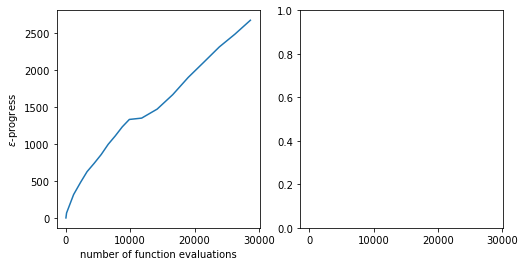

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations')
plt.show()

In [5]:
#Sum the different RfR values to identify the one with 0 for the our municiaplites. identify intresting solutions
results ["sum rfr"] = (results ['0_RfR 0'] + 
                       results ['0_RfR 1'] +
                       results ['0_RfR 2'] +
                       results ['1_RfR 0'] + 
                       results ['1_RfR 1'] +
                       results ['1_RfR 2'] +
                       results ['2_RfR 0'] + 
                       results ['2_RfR 1'] +
                       results ['2_RfR 2'])




results ["sum deaths"] = (results ['A.1_Expected Number of Deaths'] + 
                       results ['A.2_Expected Number of Deaths'] +
                       results ['A.3_Expected Number of Deaths'] +
                       results ['A.4_Expected Number of Deaths'] + 
                       results ['A.5_Expected Number of Deaths'])
                     


int_sol = results[results["sum rfr"] <= 0 ] #no RFR costs for dikes
int_solu = int_sol[int_sol['A.1_Expected Number of Deaths'] <= 0 ] #no deaths in dike 1
int_solut = int_solu[int_solu['A.2_Expected Number of Deaths'] <= 0.00148 ] #0.00148 for dike 2
int_solutions = int_solut[int_solut['A.3_Expected Number of Deaths'] <= 0.001 ] #0.001 for dike 3
# int_solutions

int_solutions


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,sum rfr,sum deaths
107,0,0,0,0,0,0,0,0,0,0,...,6.286508e+07,0.0,1.739245e+07,0.005904,7.536509e+07,0.019343,0.0,0.0,0,0.025247
128,0,0,0,0,0,0,0,0,0,0,...,9.444945e+07,0.0,3.359363e+07,0.002875,5.294609e+07,0.028814,0.0,0.0,0,0.031688
956,0,0,0,0,0,0,0,0,0,0,...,7.751737e+07,0.0,3.713830e+07,0.000000,4.419351e+07,0.000000,0.0,0.0,0,0.000000


In [7]:
#identified the lever values that provided those solutions
policies = int_solutions
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop([ "sum rfr", "sum deaths"], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
107,0,0,0,0,0,0,0,0,0,0,...,7,5,5,0,0,0,3,0,3,1
128,0,0,0,0,0,0,0,0,0,0,...,5,7,1,4,0,10,1,2,0,0
956,0,0,0,0,0,0,0,0,0,0,...,1,7,0,7,7,4,2,7,0,0


In [9]:
#From the identified levers create a Policy dictionary to be fed to the Multiprocess evaluator
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

policies_to_evaluate

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 2, 'A.1_DikeIncrease 1': 3, 'A.1_DikeIncrease 2': 1, 'A.2_DikeIncrease 0': 10, 'A.2_DikeIncrease 1': 6, 'A.2_DikeIncrease 2': 7, 'A.3_DikeIncrease 0': 5, 'A.3_DikeIncrease 1': 5, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 3, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 3, 'A.5_DikeIncrease 2': 1}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 6, 'A.1_DikeIncrease 1': 2, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 7, 'A.2_DikeIncrease 1': 5, 'A.2_DikeIncr

In [10]:
#Run scenarios ansd policies random
with MultiprocessingEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(1000, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
#Save results
from ema_workbench import save_results

save_results(results, 'identified solutions MORDM 1000scenarios.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\felo1\OneDrive\Documents\GitHub\epa1361_open_g29\final assignment\identified solutions MORDM 1000scenarios.tar.gz
